In [4]:
%matplotlib inline

import pandas as pd
import json
import requests
from urllib.parse import quote

# Get crime data 
soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
soql += quote("SELECT community_area AS Community, count(*)/5 AS Crime_Rate ")
soql += quote("WHERE 2007 < year AND year < 2013 ")
soql += quote("GROUP BY Community LIMIT 10000")

resp = requests.get(soql).json()

crime_total = pd.DataFrame(resp)

# Get rid of the redundant decimal places and NaN
crime_total.Crime_Rate = crime_total.Crime_Rate.astype(float)
crime_total.round(1) 

crime_total.dropna(axis = 0, how = "any", inplace = True)  

crime_total.tail() 


,Community,Crime_Rate
73,75,3121.8
74,76,2030.4
75,77,3612.8
76,8,11979.2
77,9,371.2


In [7]:
# Use the socioeconomics data to get the community name 

socioeconomics = pd.read_csv("data/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv", index_col = ['Community Area Number'])
crime_total.rename(columns={'Community':'Community Area Number'}, inplace = True)
crime_total.set_index('Community Area Number')

mix_total = pd.DataFrame.join(crime_total, socioeconomics).dropna(axis = 0, how = "any", inplace = True)  

# Only keep the relevant columns 
mix_total[['Community Area Number','COMMUNITY AREA NAME','Crime_Rate']].head()

,Community Area Number,COMMUNITY AREA NAME,Crime_Rate
1,1,Rogers Park,5615.4
2,10,West Ridge,1614.2
3,11,Uptown,1478.8
4,12,Lincoln Square,689.6
5,13,North Center,1247.8


In [8]:
# Rank the communities according to the crime rate 

mix_total_rank = mix_total[['Community Area Number','COMMUNITY AREA NAME','Crime_Rate']].sort_values('Crime_Rate', ascending = False) 
mix_total_rank

,Community Area Number,COMMUNITY AREA NAME,Crime_Rate
18,25,Montclaire,24329.2
38,43,Grand Boulevard,12667.4
16,23,Irving Park,12045.6
76,8,O'Hare,11979.2
64,67,Clearing,11419.4
17,24,Dunning,11141.2
69,71,Greater Grand Crossing,11000.0
22,29,Logan Square,10617.0
44,49,Chatham,10585.6
65,68,West Lawn,10347.8


In [10]:
# Curious about the number of incidents per day for the top ten "dangerous" communities

mix_total_perday = mix_total_rank.assign(Crime_Rate_Perday = mix_total_rank["Crime_Rate"]/365) 
mix_total_perday.head(10) 

,Community Area Number,COMMUNITY AREA NAME,Crime_Rate,Crime_Rate_Perday
18,25,Montclaire,24329.2,66.655342
38,43,Grand Boulevard,12667.4,34.705205
16,23,Irving Park,12045.6,33.001644
76,8,O'Hare,11979.2,32.819726
64,67,Clearing,11419.4,31.286027
17,24,Dunning,11141.2,30.523836
69,71,Greater Grand Crossing,11000.0,30.136986
22,29,Logan Square,10617.0,29.087671
44,49,Chatham,10585.6,29.001644
65,68,West Lawn,10347.8,28.350137


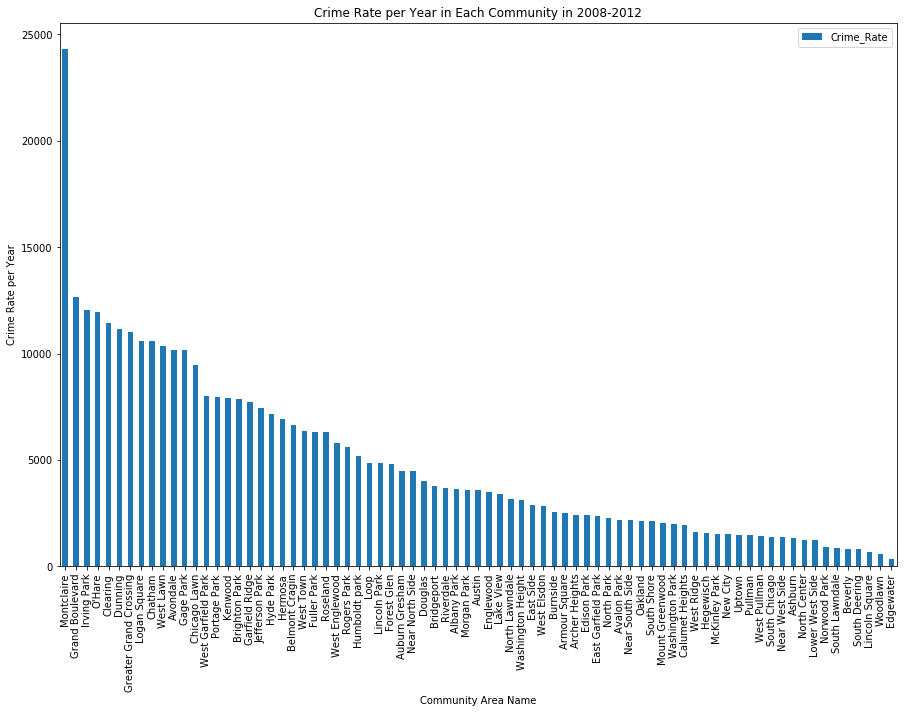

In [14]:
# Make a graph to show the information  
mix_total_rank_new = mix_total_rank[['COMMUNITY AREA NAME','Crime_Rate']] 

ax = mix_total_rank_new.set_index('COMMUNITY AREA NAME').plot(kind = "bar", figsize = (15, 10))
ax.set_xlabel("Community Area Name")
ax.set_ylabel("Crime Rate per Year")  
ax.set_title("Crime Rate per Year in Each Community in 2008-2012")

ax.figure.savefig("Crime_Rate_per_Year_Final.pdf")

In [ ]:
# Notice that there is a great disparity among communities with respect to average crime rate per year. 

In [15]:
# Now turn to the type of crime
import pandas as pd
import json
import requests
from urllib.parse import quote
%matplotlib inline 

# Get crime data 
soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
soql += quote("SELECT community_area AS Community, count(*)/5 AS Crime_Rate, primary_type AS Primary_Type ")
soql += quote("WHERE 2007 < year AND year < 2013 ")
soql += quote("GROUP BY Community, Primary_Type LIMIT 10000")

resp = requests.get(soql).json()

crime_type = pd.DataFrame(resp) 

crime_type.Crime_Rate = crime_type.Crime_Rate.astype(float)
crime_type.round(1) 

crime_type.dropna(axis = 0, how = "any", inplace = True) 

# Find out all the types of crime
crime_type["Primary_Type"].unique()


array(['ASSAULT', 'BATTERY', 'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS',
       'DECEPTIVE PRACTICE', 'MOTOR VEHICLE THEFT', 'NARCOTICS',
       'OTHER OFFENSE', 'THEFT', 'ARSON', 'BURGLARY',
       'CRIM SEXUAL ASSAULT', 'GAMBLING', 'HOMICIDE',
       'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION', 'KIDNAPPING',
       'LIQUOR LAW VIOLATION', 'OBSCENITY', 'OFFENSE INVOLVING CHILDREN',
       'PROSTITUTION', 'PUBLIC INDECENCY', 'PUBLIC PEACE VIOLATION',
       'ROBBERY', 'SEX OFFENSE', 'STALKING', 'WEAPONS VIOLATION',
       'OTHER NARCOTIC VIOLATION', 'NON-CRIMINAL (SUBJECT SPECIFIED)',
       'NON-CRIMINAL'], dtype=object)

In [18]:
# again, merge data sets to get the community name
socioeconomics = pd.read_csv("data/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv")
crime_type.rename(columns={'Community':'Community Area Number'}, inplace = True)
crime_type['Community Area Number'] = crime_type['Community Area Number'].astype(float)
mix_type = pd.DataFrame.merge(crime_type, socioeconomics, on = 'Community Area Number')
mix_type

,Community Area Number,Crime_Rate,Primary_Type,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,4.6,ARSON,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,1.0,344.8,ASSAULT,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
2,1.0,1038.6,BATTERY,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
3,1.0,279.6,BURGLARY,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
4,1.0,630.6,CRIMINAL DAMAGE,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
5,1.0,221.0,CRIMINAL TRESPASS,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
6,1.0,22.6,CRIM SEXUAL ASSAULT,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
7,1.0,206.0,DECEPTIVE PRACTICE,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
8,1.0,11.0,GAMBLING,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
9,1.0,4.0,HOMICIDE,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0


In [19]:
# Keep the relevant columns 

mix_type_new = mix_type[['Community Area Number','COMMUNITY AREA NAME','Crime_Rate','Primary_Type']]
mix_type_new.head()

,Community Area Number,COMMUNITY AREA NAME,Crime_Rate,Primary_Type
0,1.0,Rogers Park,4.6,ARSON
1,1.0,Rogers Park,344.8,ASSAULT
2,1.0,Rogers Park,1038.6,BATTERY
3,1.0,Rogers Park,279.6,BURGLARY
4,1.0,Rogers Park,630.6,CRIMINAL DAMAGE


In [21]:
# Curious about what types of crime have the highest occurrence. 

mix_type_sum = mix_type_new.groupby('Primary_Type').sum() 
mix_type_sum_rank = mix_type_sum[['Crime_Rate']].sort_values('Crime_Rate', ascending = False) 

mix_type_sum_rank

# Top five types are: theft, battery, criminal damage, narcotics, and burglary. 

,Crime_Rate
Primary_Type,
THEFT,79305.0
BATTERY,65847.6
CRIMINAL DAMAGE,42858.0
NARCOTICS,41493.6
BURGLARY,25757.4
OTHER OFFENSE,22352.4
ASSAULT,22016.8
MOTOR VEHICLE THEFT,17850.6
ROBBERY,14881.4


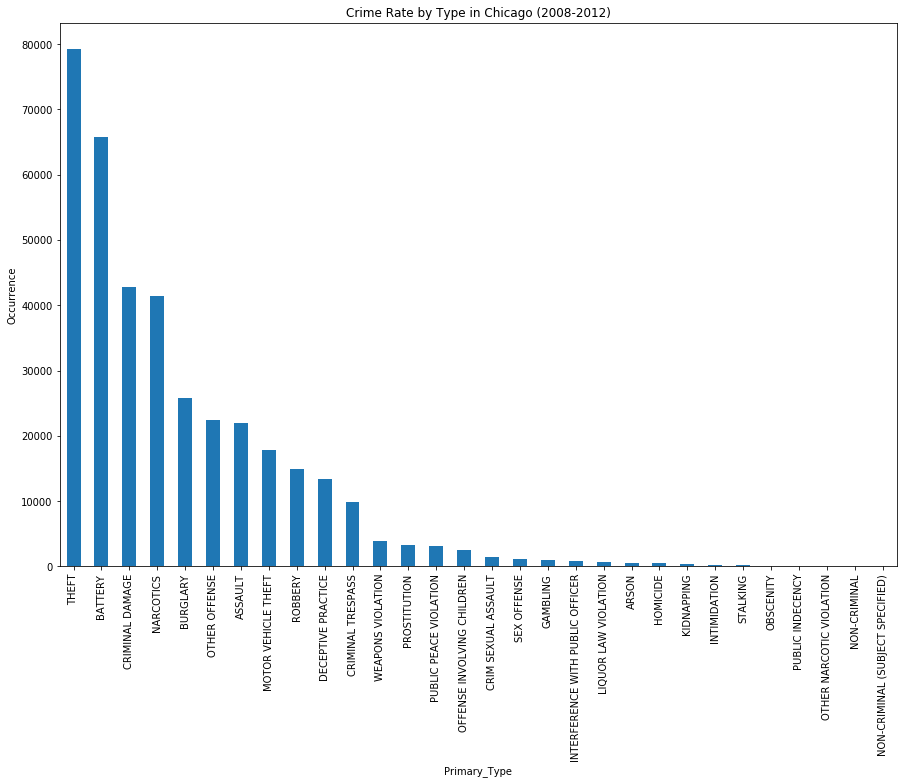

In [22]:
# Show the information on a graph 
ax = mix_type_sum_rank["Crime_Rate"].plot(kind = "bar", figsize = (15, 10))
ax.set_ylabel("Occurrence")  
ax.set_title("Crime Rate by Type in Chicago (2008-2012)")

ax.figure.savefig("Crime_Rate_by_Type_Final.pdf") 